In [8]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

In [9]:
from experiments import OptimalSensorChoice
from experiments import utilities as utils
from bayesinverse import Regression

In [10]:
config_path = config_path = Path(
    "/home/rmaiwald/code/Experiments/experiments/optimal_sensor_choice/config.yaml"
)

exp = OptimalSensorChoice(config_path)


sensors 0.009511023759841919
emissions 9.008361101150513
transport 12.672569543123245


In [11]:
exp.K = exp.transport.get_transport(
    exp.sensors.n_sensors, exp.sensors.get_index(), exp.emissions, n_processes=30,
)


loop start 16.055494502186775
loop end 16.086008116602898


In [12]:
true_emissions = exp.emissions.get_absolute()[exp.emissions.mask]


In [19]:
n_mc = 100
n_time = 24

n_sensors_list = [5, 10, 15, 20, 25, 30]
std_list = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0]
rmse_list = []
information_list = []
for n_sensors_sample in n_sensors_list:
    print(n_sensors_sample)
    for std in std_list:
        for i in range(n_mc):
            time_ids = exp.transport.get_time_ids(time=n_time)
            sensor_ids = exp.sensors.get_sample_ids(n_sensors_sample)
            exp.sensors.set_std(std)
            reg = Regression(
                y=utils.stack_xr(
                    exp.K.isel(time_measurement=time_ids, sensor=sensor_ids)
                    @ exp.emissions.truth
                    + exp.sensors.get_noise(n_sensors_sample).isel(
                        time_measurement=time_ids
                    )
                ).values,
                K=utils.stack_xr(
                    exp.K.isel(time_measurement=time_ids, sensor=sensor_ids)
                ).values,
                x_prior=utils.stack_xr(exp.emissions.prior).values,
                x_covariance=utils.stack_xr(exp.emissions.prior_covariance).values,
                y_covariance=utils.stack_xr(
                    exp.sensors.get_covariance().isel(
                        time_measurement=time_ids, sensor=sensor_ids
                    )
                ).values,
            )
            information_list.append(reg.get_information_content())
            x_est, _, _, _ = reg.fit()
            x_posterior = exp.emissions.to_xr(x_est)
            x_posterior = utils.unstack_xr(x_posterior) * true_emissions
            # error = exp.emissions.truth_absolute * (exp.emissions.truth - x_posterior)
            # rmse = np.sqrt(np.mean(error**2))
            rmse = np.sqrt(
                np.mean(
                    exp.emissions.truth_absolute.sum(
                        dim="source_group"
                    )
                    - x_posterior.sum(dim="source_group")
                )
                ** 2
            )
            rmse_list.append(rmse)

std_list.reverse()
n_sensors_list.reverse()


5
10
15
20
25
30


ValueError: x and y can be no greater than 2D, but have shapes (21,) and (21, 1, 21)

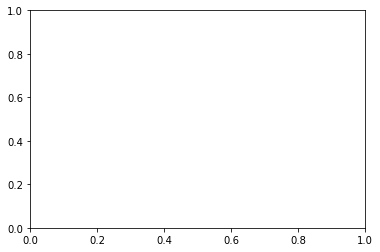

In [16]:
plt.plot(x_posterior * utils.stack_xr(exp.emissions.truth_absolute))
plt.plot(exp.emissions.truth_absolute)
plt.plot(exp.emissions.prior_absolute)
print((x_posterior * utils.stack_xr(exp.emissions.truth_absolute)).sum())
print(exp.emissions.truth_absolute.sum())
print(exp.emissions.prior_absolute.sum())

In [20]:
rmse = np.array(rmse_list).reshape(len(n_sensors_list), len(std_list), n_mc)
rmse = np.flip(rmse.mean(axis=2))
rmse = rmse / np.sum(exp.emissions.truth_absolute).values * 100
rmse.min()

0.5077802877719934

Error from prior: <xarray.DataArray ()>
array(61.03246421)


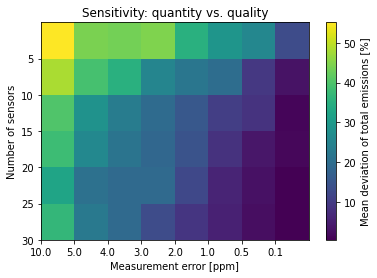

In [26]:
pcm = plt.pcolormesh(rmse)

plt.xticks(np.arange(len(std_list)), std_list)
plt.yticks(np.arange(len(n_sensors_list)), n_sensors_list)
cbar = plt.colorbar(pcm)
cbar.set_label("Mean deviation of total emissions [%]")
print(
    "Error from prior: {}".format(
        np.abs(exp.emissions.prior_absolute.sum() - exp.emissions.truth_absolute.sum())
        / np.sum(exp.emissions.truth_absolute).values
        * 100
    )
)
plt.xlabel("Measurement error [ppm]")
plt.ylabel("Number of sensors")
plt.title("Sensitivity: quantity vs. quality")
plt.savefig("/home/rmaiwald/results/preliminary/opt_sensor_choice_rmse")

In [27]:
information = np.array(information_list).reshape(len(n_sensors_list), len(std_list), n_mc)
information = np.flip(information.mean(axis=2))


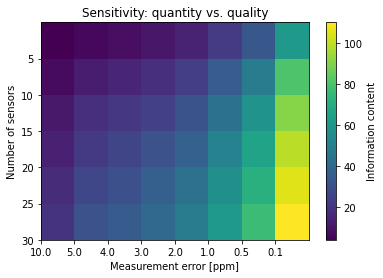

In [28]:
pcm = plt.pcolormesh(information)

plt.xticks(np.arange(len(std_list)), std_list)
plt.yticks(np.arange(len(n_sensors_list)), n_sensors_list)
cbar = plt.colorbar(pcm)
cbar.set_label("Information content")

plt.xlabel("Measurement error [ppm]")
plt.ylabel("Number of sensors")
plt.title("Sensitivity: quantity vs. quality")
plt.savefig("/home/rmaiwald/results/preliminary/opt_sensor_choice_information")